<a href="https://www.kaggle.com/code/dilekdd/multi-class-classification-problem?scriptVersionId=203780934" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

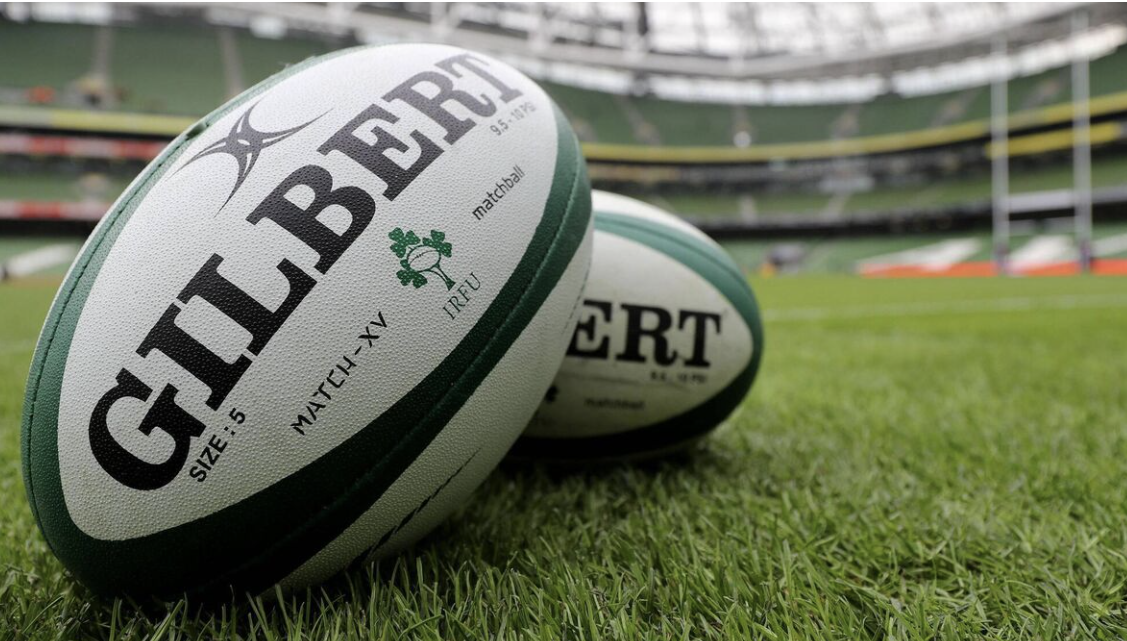

In [1]:
from PIL import Image
from IPython.display import display

# Open and display the image
img = Image.open('/kaggle/input/rugby-international/Rugby.png')
display(img)

# Dataset and Business Problem

Rugby is a highly competitive sport with numerous international tournaments such as the Six Nations, The Rugby Championship, and the Rugby World Cup. 

National rugby teams face constant pressure to perform at their best in high-stakes matches. Historically, results have shown that factors such as team form, home-field advantage, and match location can significantly influence game outcomes. 

In the modern era of data-driven decision-making, teams need to leverage historical match data to improve their strategies, training, and match preparations.


The goal is to build a predictive analytics model that accurately forecasts the outcomes of international rugby matches, using historical data to optimize match preparations, team selection, and strategies. 



# **Data Dictionary**

| **Column Name**  | **Description**                                                                 |
|------------------|---------------------------------------------------------------------------------|
| `date`           | The date on which the match was played. Format: YYYY-MM-DD.                     |
| `home_team`      | The name of the team playing at their home venue or designated as the home team. |
| `away_team`      | The name of the opposing team playing at an away venue or designated as away.    |
| `home_score`     | The number of points scored by the home team in the match.                       |
| `away_score`     | The number of points scored by the away team in the match.                       |
| `competition`    | The name of the tournament or competition in which the match was played.         |
| `stadium`        | The name of the stadium where the match was held.                                |
| `city`           | The city in which the match took place.                                          |
| `country`        | The country in which the match was held.                                         |
| `neutral`        | A boolean flag indicating whether the match was played at a neutral venue.       |
| `world_cup`      | A boolean flag indicating if the match was part of the Rugby World Cup.          |



# Imports and Display Settings

In [2]:
!pip install missingno
!pip install imbalanced-learn

#importing the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report,  RocCurveDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_predict, cross_val_score
import warnings
warnings.simplefilter(action="ignore")

# Adjusting the display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Loading the Dataset

In [3]:
df = pd.read_csv("/kaggle/input/international-rugby-union-results-from-18712022/results.csv")

# Exploratory Data Analysis and Creating the Target Variable

In [4]:
#this function provides a quik summary about the dataset
def quick_summary(dataframe, head=2):
    print("##################### HEAD #####################")
    print(dataframe .head(head))
    print("##################### TAIL #####################")
    print(dataframe.tail(head))
    print("##################### SHAPE #####################")
    print(dataframe.shape)
    print("##################### MISSING VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### QUANTILES #####################")
    print(dataframe.describe(include=['number']).T)
    print("##################### INFO #####################")
    print(dataframe.info())
quick_summary(df)

##################### HEAD #####################
         date home_team away_team  home_score  away_score                            competition        stadium       city   country  neutral  world_cup
0  1871-03-27  Scotland   England           1           0  1871 Scotland v England International  Raeburn Place  Edinburgh  Scotland    False      False
1  1872-02-05   England  Scotland           2           1     1871–72 Home Nations International       The Oval     London   England    False      False
##################### TAIL #####################
            date    home_team     away_team  home_score  away_score              competition        stadium      city      country  neutral  world_cup
2781  2024-08-17  New Zealand     Argentina          42          10  2024 Rugby Championship      Eden Park  Auckland  New Zealand     True      False
2782  2024-08-17    Australia  South Africa          12          30  2024 Rugby Championship  Optus Stadium     Perth    Australia    False  

In [5]:
#dentifying and categorizing the column names of the DataFrame into three types: categorical columns (cat_cols), 
#numerical columns (num_cols), #and categorical but cardinal columns (cat_but_car)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Provides the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numeric appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Threshold value for numeric but categorical variables
        car_th: int, optinal
                Threshold for categorical but not cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                categorical but cardinal list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total variable count 
        num_but_cat is included in cat_cols
        3 lists that is returned are equal to the total variable count: cat_cols + num_cols + cat_but_car = total variable count

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes in ["int", "float"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2783
Variables: 11
cat_cols: 5
num_cols: 2
cat_but_car: 4
num_but_cat: 0


In [6]:
#updating 'date' variable's data type
df['date'] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors='coerce')

#extracting year from date 
df["year"] = df["date"].dt.year

#extracting month from date 
df["month"] = df["date"].dt.month

#converting month and year to int64
df['year'] = df['year'].astype('int64')

df["month"] = df["month"].astype('int64')

#dropping date variable from the dataset
df = df.drop(["date"], axis=1)

In [7]:
# This code identifies competition group based on keywords and assigns specific group names.
def assign_competition_group(df, keyword, group_name):
    df["competition_group"] = np.where(
        (df["competition"].str.contains(keyword, case=False, na=False)) & (df["competition_group"] == "Other"),
        group_name,
        df["competition_group"]
    )
    return df

# initialize the competition_group column with "Other"
df["competition_group"] = "Other"

# # Use the function to assign specific group names based on keywords
# df = assign_competition_group(df, "World Cup", "World Cup")
# df = assign_competition_group(df, "Six Nations", "Six Nations")
# df = assign_competition_group(df, "tour", "Tour")
# df = assign_competition_group(df, "Home Nations", "Six Nations")
# df = assign_competition_group(df, "European Cup", "European Cup")
# df = assign_competition_group(df, "test", "Friendly")
# df = assign_competition_group(df, "international", "internationals")
# df = assign_competition_group(df, "Five Nations", "Five Nations")
# df = assign_competition_group(df, "Championship", "The Rugby Championship")
# df = assign_competition_group(df, "Tri Nations", "The Rugby Championship")
# df = assign_competition_group(df, "Nations Cup", "Nations Cup")

# Assign specific group names to the 'competition_group' column based on the 'competition' keyword.
keywords = ["World Cup", "Six Nations", "tour", "Home Nations",  "test", "Test", "Five Nations", "Championship", "Tri Nations", "Autumn Nations Cup", "Autumn", "end-of-year", "Summer", "mid-year"]
group_names = ["World Cup", "Six Nations", "Tour", "Six Nations", "Test Matches", "Test Matches", "Six Nations", "The Rugby Championship", "The Rugby Championship", "Autumn Nations Cup", "Autumn Internationals", "Autumn Internationals", "Summer Nations Series", "Summer Nations Series"]


# Loop through keywords and assign the corresponding group names.
for keyword, group_name in zip(keywords, group_names):
    df = assign_competition_group(df, keyword, group_name)

# Standardize stadium names (e.g., "Twickenham" becomes "Twickenham Stadium").
df["stadium"] = np.where(df["stadium"].str.contains("Twickenham", case=False, na=False),
                         "Twickenham Stadium", df["stadium"])

df["stadium"] = np.where(df["stadium"].str.contains("Lansdowne Road", case=False, na=False),
                         "Aviva Stadium", df["stadium"])
df.head()

,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup,year,month,competition_group
0,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False,1871,3,Other
1,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False,1872,2,Six Nations
2,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False,1873,3,Six Nations
3,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False,1874,2,Six Nations
4,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False,1875,2,Six Nations


In [8]:
# Creating a column to indicate the home team result
df['home_team_result'] = df.apply(lambda x: 'Win' if x['home_score'] > x['away_score'] else ('Loss' if x['home_score'] < x['away_score'] else 'Draw'), axis=1)

# Creating a column to indicate the away team result
df['away_team_result'] = df.apply(lambda x: 'Win' if x['away_score'] > x['home_score'] else ('Loss' if x['away_score'] < x['home_score'] else 'Draw'), axis=1)

# Creating a column to indicate the overall match result
df['result'] = df.apply(lambda x: 'Home Win' if x['home_score'] > x['away_score'] else ('Away Win' if x['away_score'] > x['home_score'] else 'Draw'), axis=1)

# Inspecting the dataframe
df[['home_team', 'away_team', 'home_score', 'away_score', 'home_team_result', 'away_team_result', 'result']].head()

,home_team,away_team,home_score,away_score,home_team_result,away_team_result,result
0,Scotland,England,1,0,Win,Loss,Home Win
1,England,Scotland,2,1,Win,Loss,Home Win
2,Scotland,England,0,0,Draw,Draw,Draw
3,England,Scotland,1,0,Win,Loss,Home Win
4,England,Ireland,2,0,Win,Loss,Home Win


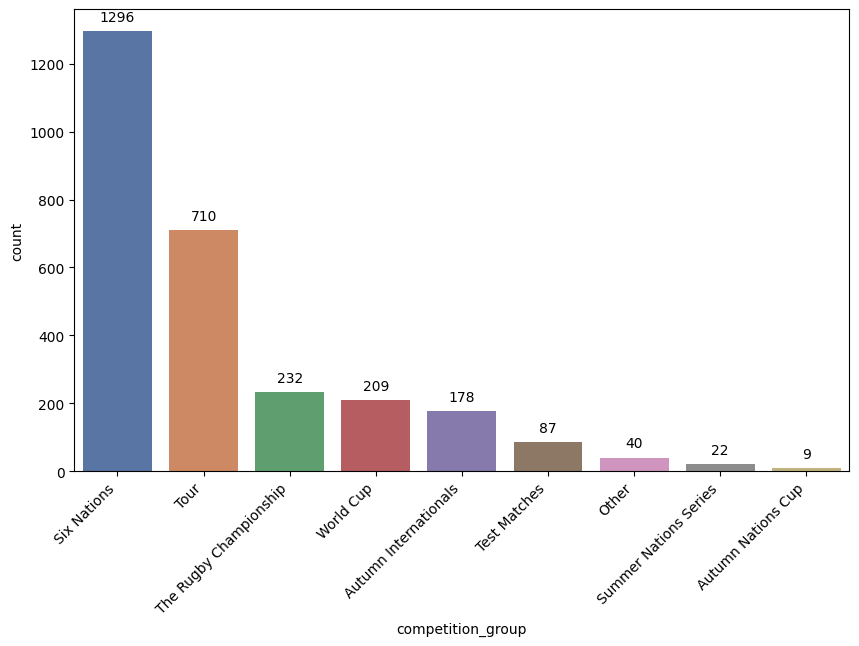

In [9]:
# This line gets the order of competition groups by their frequency in the dataset.
sorted_order = df["competition_group"].value_counts().index

# Create a figure with a specified size for the plot.
plt.figure(figsize=(10, 6))

# Create a countplot to display the count of occurrences for each 'competition_group',
# and order them based on their frequency.
ax = sns.countplot(x=df["competition_group"], data=df, order=sorted_order, palette="deep")

# Add annotations to each bar in the countplot, displaying the count on top of each bar.
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  # Format count as an integer.
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Set position of annotation.
                ha = 'center', va = 'bottom',  # Center the text above the bar.
                xytext = (0, 5),  # Set the offset for the text from the bar.
                textcoords = 'offset points')

# Rotate the x-axis labels by 45 degrees for better readability, align them to the right.
plt.xticks(rotation=45, ha='right')

# Show the plot.
plt.show()


In [10]:
# Creating a column 'winner' that contains the winning team for each match
df['winner'] = df.apply(lambda row: row['home_team'] if row['home_team_result'] == 'Win' else (row['away_team'] if row['away_team_result'] == 'Win' else 'Draw'), axis=1)

# Filtering out draws, as we only care about wins
df_wins = df[df['winner'] != 'Draw']

#dropping the following features to avoid data leakage
df_wins = df_wins.drop(columns=['home_team_result', 'away_team_result', 'result'], axis=1)

df_wins.head()
df_wins["competition_group"].nunique()
df_wins["competition_group"].value_counts()

# Counting the number of wins for each team
team_wins = df_wins['winner'].value_counts()

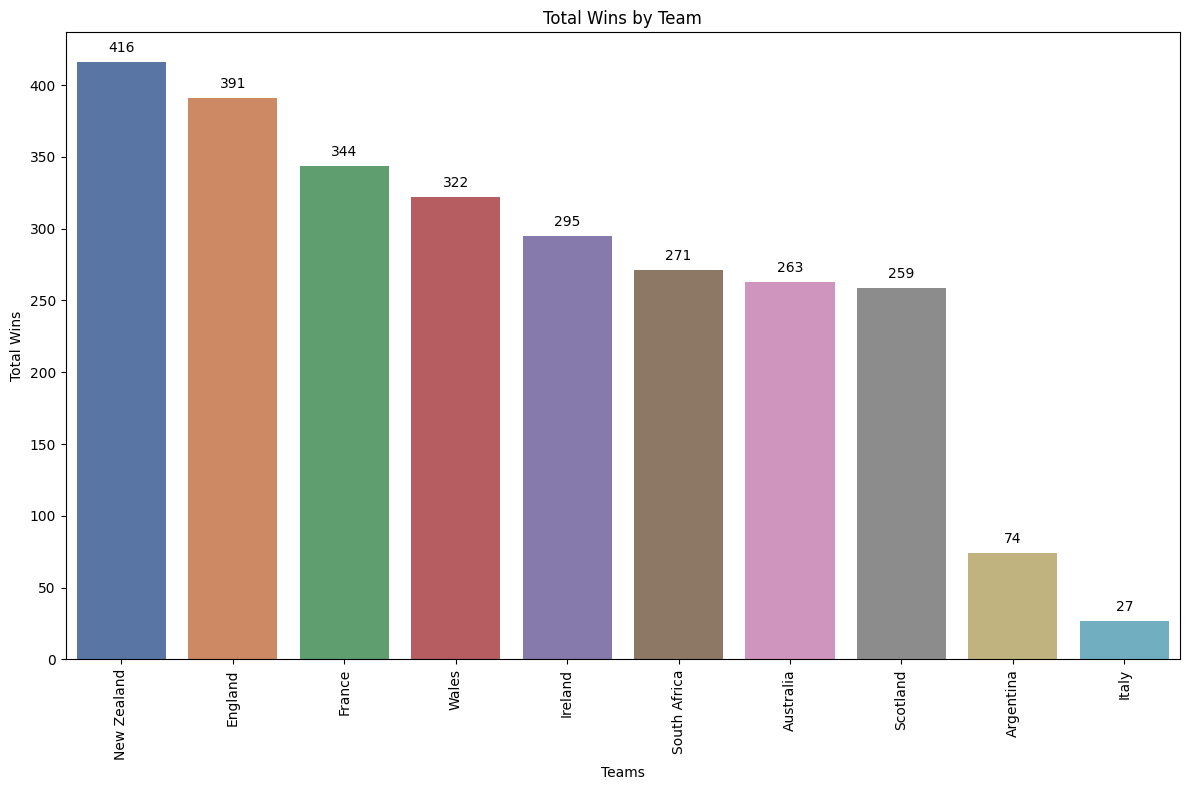

In [11]:
# Plotting the total wins for each team
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=team_wins.index, y=team_wins.values, palette="deep")

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.xticks(rotation=90, ha='center')
plt.xlabel('Teams')
plt.ylabel('Total Wins')
plt.title('Total Wins by Team')
plt.tight_layout()
plt.show()

In [12]:
# checking the distribution of the multiclass target variable
df_wins['winner'].value_counts()

winner
New Zealand     416
England         391
France          344
Wales           322
Ireland         295
South Africa    271
Australia       263
Scotland        259
Argentina        74
Italy            27
Name: count, dtype: int64

In [13]:
# checking the distribution of the multiclass target variable
df_wins['winner'].value_counts(normalize=True) * 100

winner
New Zealand    15.627
England        14.688
France         12.923
Wales          12.096
Ireland        11.082
South Africa   10.180
Australia       9.880
Scotland        9.730
Argentina       2.780
Italy           1.014
Name: proportion, dtype: float64

In [14]:
# This line calls the 'grab_col_names' function to identify and separate different types of columns in the dataframe.
cat_cols, num_cols, cat_but_car = grab_col_names(df_wins)

Observations: 2662
Variables: 14
cat_cols: 7
num_cols: 4
cat_but_car: 3
num_but_cat: 0


              home_team  Ratio
home_team                     
England             361 13.561
Wales               354 13.298
Ireland             334 12.547
Scotland            327 12.284
France              325 12.209
New Zealand         258  9.692
Australia           252  9.467
South Africa        200  7.513
Argentina           134  5.034
Italy               117  4.395
##########################################


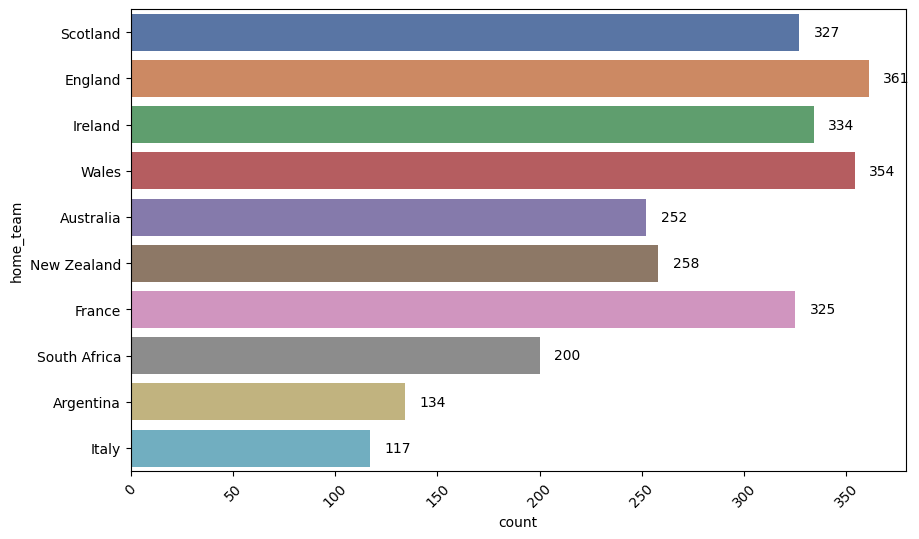

              away_team  Ratio
away_team                     
France              330 12.397
England             328 12.322
Ireland             318 11.946
Scotland            310 11.645
Wales               310 11.645
Australia           285 10.706
New Zealand         275 10.331
South Africa        228  8.565
Italy               140  5.259
Argentina           138  5.184
##########################################


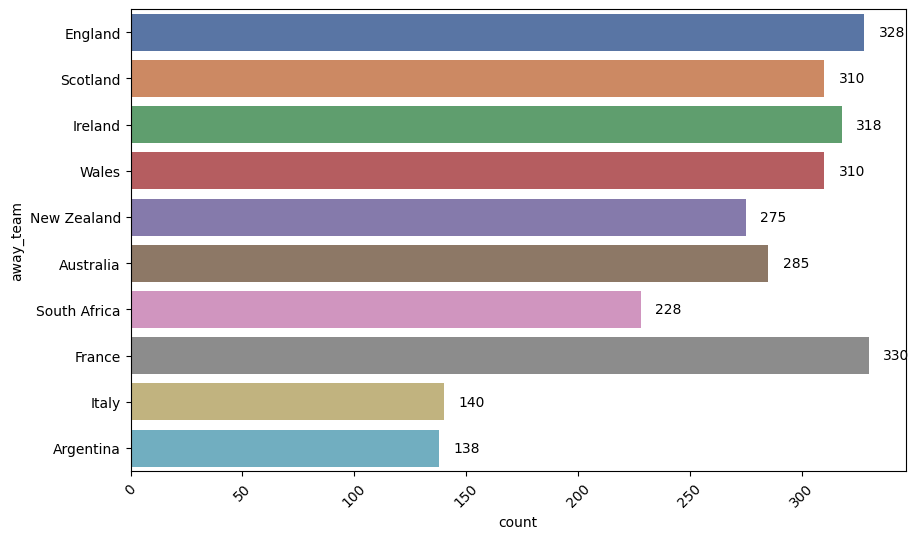

               country  Ratio
country                      
England            366 13.749
Wales              349 13.110
France             338 12.697
Scotland           325 12.209
Ireland            323 12.134
Australia          260  9.767
New Zealand        243  9.128
South Africa       201  7.551
Argentina          121  4.545
Italy              115  4.320
Japan               15  0.563
United States        3  0.113
Hong Kong            2  0.075
Singapore            1  0.038
##########################################


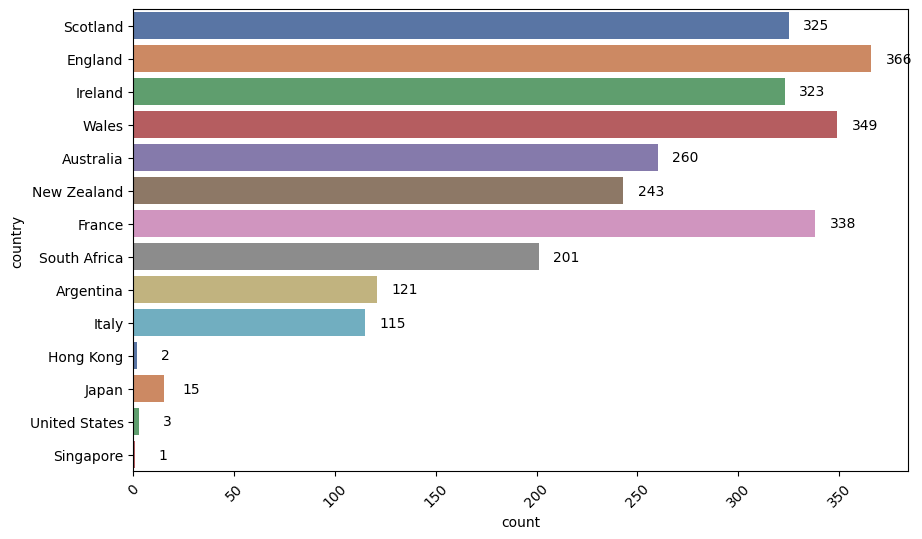

         neutral  Ratio
neutral                
False       2536 95.267
True         126  4.733
##########################################


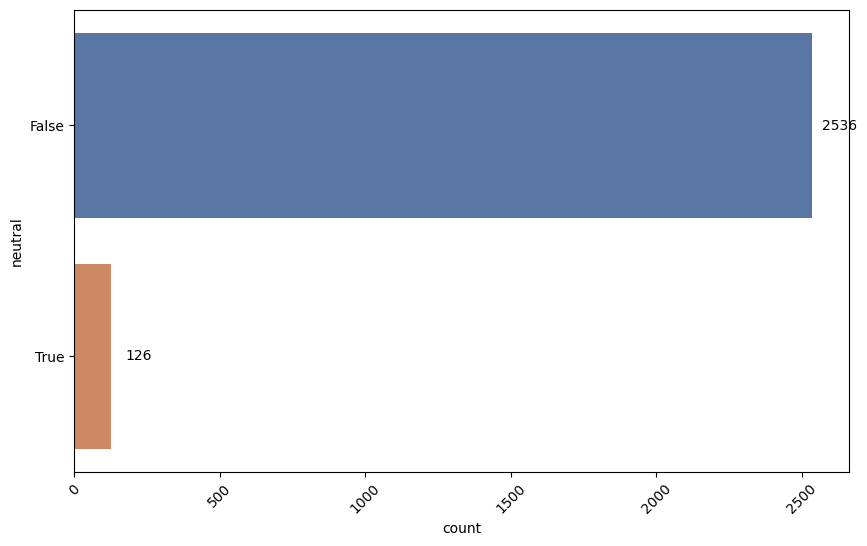

           world_cup  Ratio
world_cup                  
False           2516 94.515
True             146  5.485
##########################################


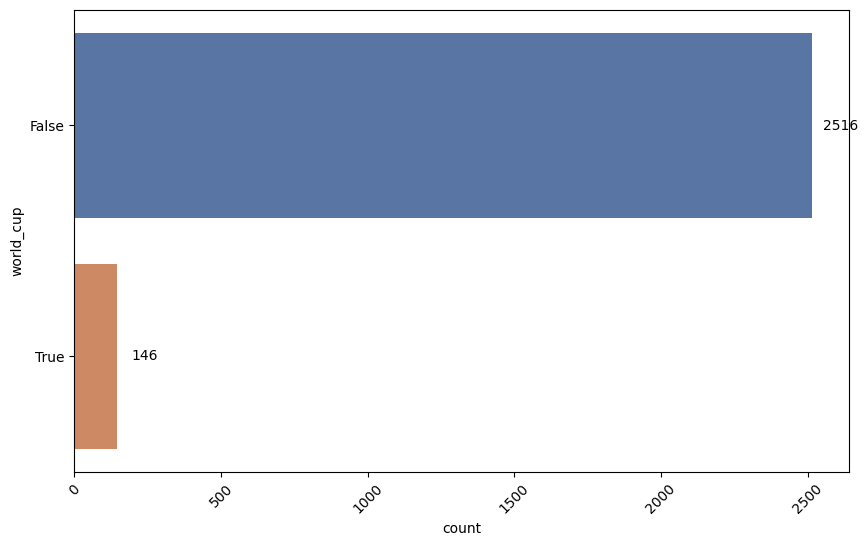

                        competition_group  Ratio
competition_group                               
Six Nations                          1221 45.868
Tour                                  680 25.545
The Rugby Championship                224  8.415
World Cup                             208  7.814
Autumn Internationals                 172  6.461
Test Matches                           87  3.268
Other                                  39  1.465
Summer Nations Series                  22  0.826
Autumn Nations Cup                      9  0.338
##########################################


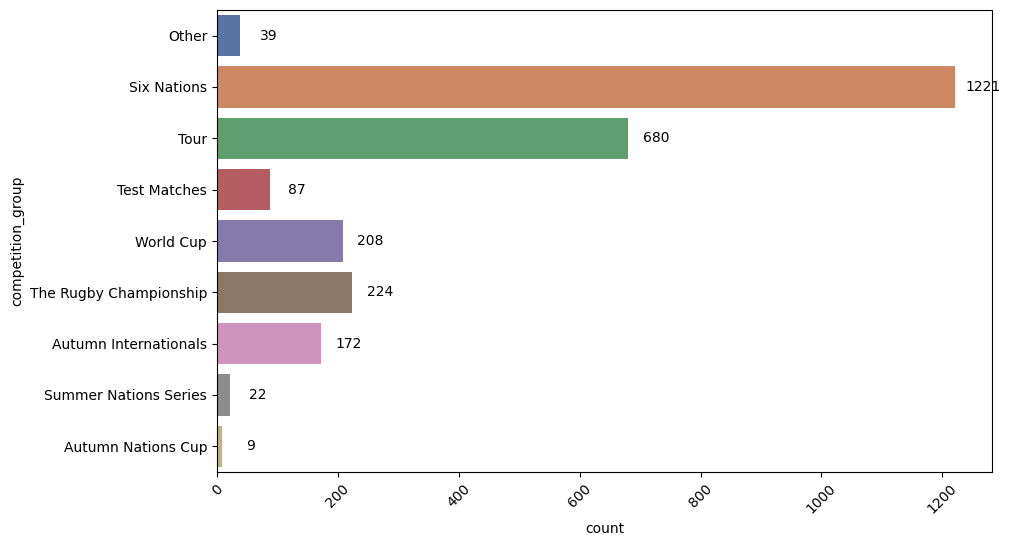

              winner  Ratio
winner                     
New Zealand      416 15.627
England          391 14.688
France           344 12.923
Wales            322 12.096
Ireland          295 11.082
South Africa     271 10.180
Australia        263  9.880
Scotland         259  9.730
Argentina         74  2.780
Italy             27  1.014
##########################################


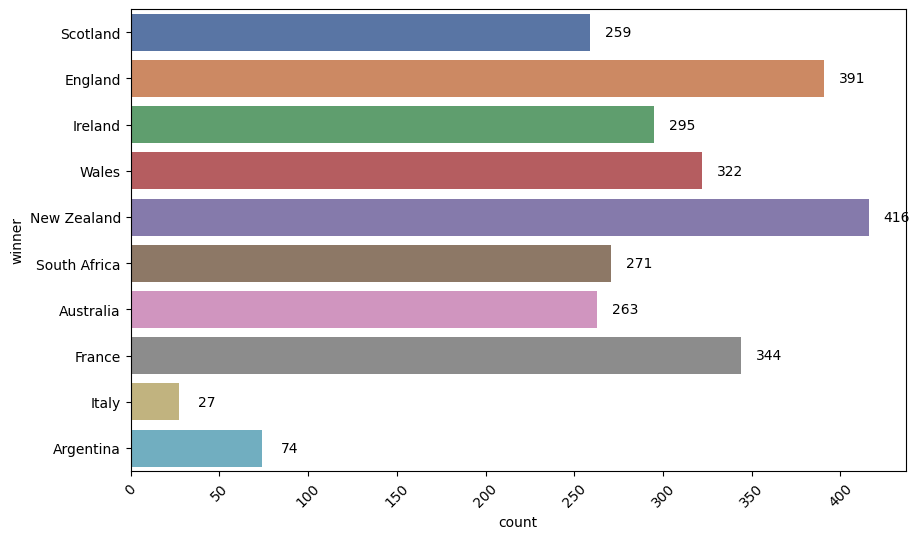

In [15]:
# This function generates a summary for a given categorical column in a dataframe.
def cat_summary(dataframe, categorical_col, plot=False):
    # Prints the counts and ratios (percentages) of unique values in the categorical column.
    print(pd.DataFrame({categorical_col: dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}))
    print("##########################################")

    # If plot=True, a bar plot will be generated for the categorical column.
    if plot:
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(y=categorical_col, data=dataframe, palette="deep")  # Bar plot with custom color palette

        # Adds data labels to each bar on the plot
        for p in ax.patches:
            ax.annotate(format(p.get_width(), '.0f'),
                        (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='center', va='center',
                        xytext=(20, 0),  # Shifts the text along the y-axis
                        textcoords='offset points')

        # Rotates the x-axis labels by 45 degrees
        plt.xticks(rotation=45)
        plt.show(block=True)


# Applies the cat_summary function to each categorical column in the dataframe and plots them.
for col in cat_cols:
    cat_summary(df_wins, col, plot=True)

count   2662.000
mean      19.211
std       13.460
min        0.000
5%         2.000
10%        3.000
20%        8.000
30%       11.000
40%       14.000
50%       17.000
60%       21.000
70%       24.000
80%       29.000
90%       36.000
95%       44.000
99%       61.000
max      101.000
Name: home_score, dtype: float64


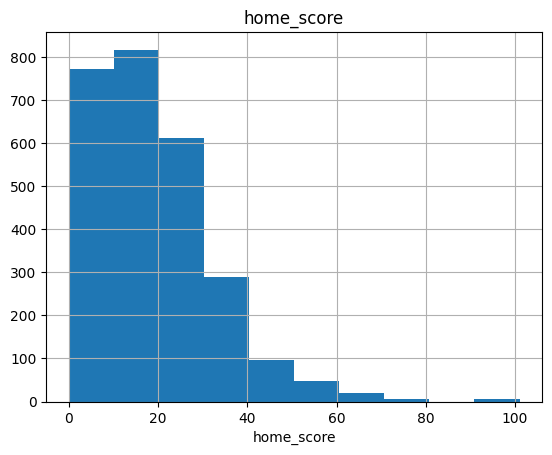

count   2662.000
mean      15.897
std       11.495
min        0.000
5%         0.000
10%        3.000
20%        6.000
30%        9.000
40%       12.000
50%       14.000
60%       17.000
70%       20.000
80%       24.000
90%       31.000
95%       38.000
99%       52.000
max       70.000
Name: away_score, dtype: float64


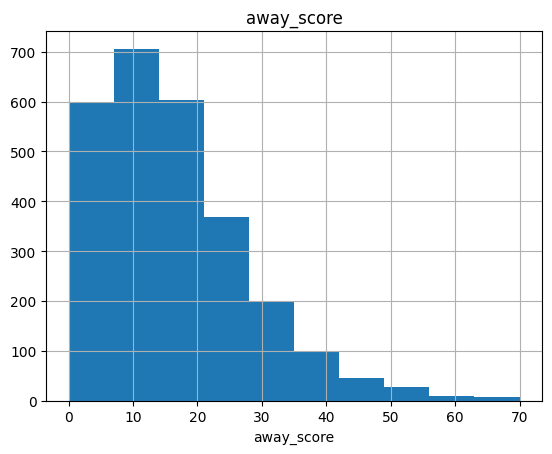

count   2662.000
mean    1981.764
std       36.901
min     1871.000
5%      1905.000
10%     1922.000
20%     1953.000
30%     1969.000
40%     1985.000
50%     1995.000
60%     2002.000
70%     2008.000
80%     2013.000
90%     2018.000
95%     2021.000
99%     2023.390
max     2024.000
Name: year, dtype: float64


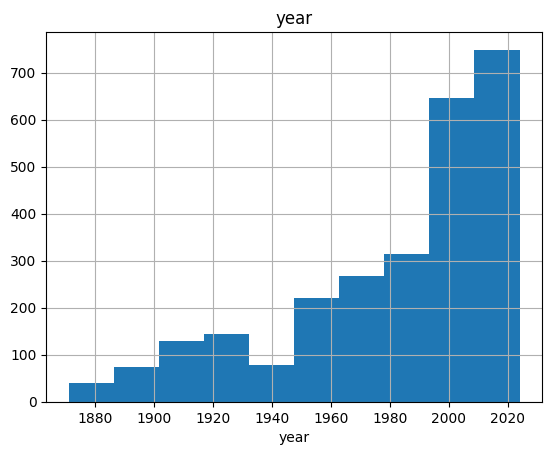

count   2662.000
mean       5.556
std        3.525
min        1.000
5%         1.000
10%        2.000
20%        2.000
30%        3.000
40%        3.000
50%        6.000
60%        6.000
70%        8.000
80%       10.000
90%       11.000
95%       11.000
99%       12.000
max       12.000
Name: month, dtype: float64


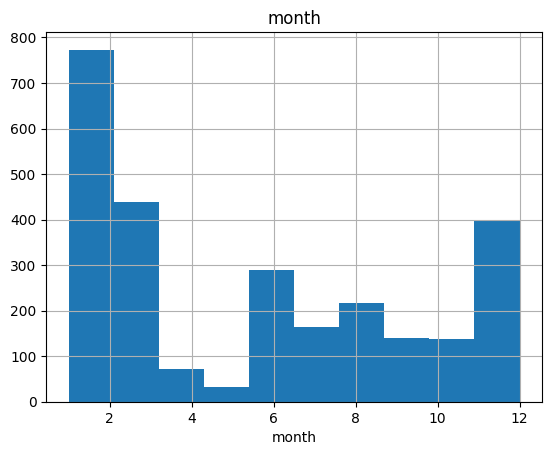

In [16]:
# This function generates a summary for a given numerical column in a dataframe.
def num_summary(dataframe, numerical_col, plot=False):
    # Prints the descriptive statistics for the numerical column including custom quantiles.
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    # If plot=True, it generates a histogram for the numerical column.
    if plot:
        dataframe[numerical_col].hist()  # Generates a histogram
        plt.xlabel(numerical_col)  # Sets the x-axis label
        plt.title(numerical_col)  # Sets the title of the plot
        plt.show(block=True)

# Iterates through each numerical column and applies the num_summary function.
for col in num_cols:
    num_summary(df_wins, col, plot=True)


In [17]:
# This function calculates and prints the average of a numerical column for each category in the target variable.
def target_summary_with_num(dataframe, target, numerical_col):
    # Group by the target variable and calculate the mean of the numerical column for each target category.
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

# Iterates through each numerical column and applies the target_summary_with_num function.
for col in num_cols:
    target_summary_with_num(df_wins, "winner", col)


              home_score
winner                  
Argentina         22.716
Australia         22.255
England           17.476
France            19.076
Ireland           17.271
Italy             23.556
New Zealand       22.781
Scotland          14.448
South Africa      22.122
Wales             16.351


              away_score
winner                  
Argentina         21.838
Australia         18.985
England           13.396
France            16.439
Ireland           13.112
Italy             21.407
New Zealand       19.774
Scotland          11.081
South Africa      19.387
Wales             12.488


                 year
winner               
Argentina    2006.514
Australia    1995.483
England      1972.008
France       1987.424
Ireland      1977.186
Italy        2006.630
New Zealand  1991.168
Scotland     1960.896
South Africa 1992.849
Wales        1968.087


              month
winner             
Argentina     8.338
Australia     8.217
England       4.015
France        4.491
Ireland   

# Correlation Matrix

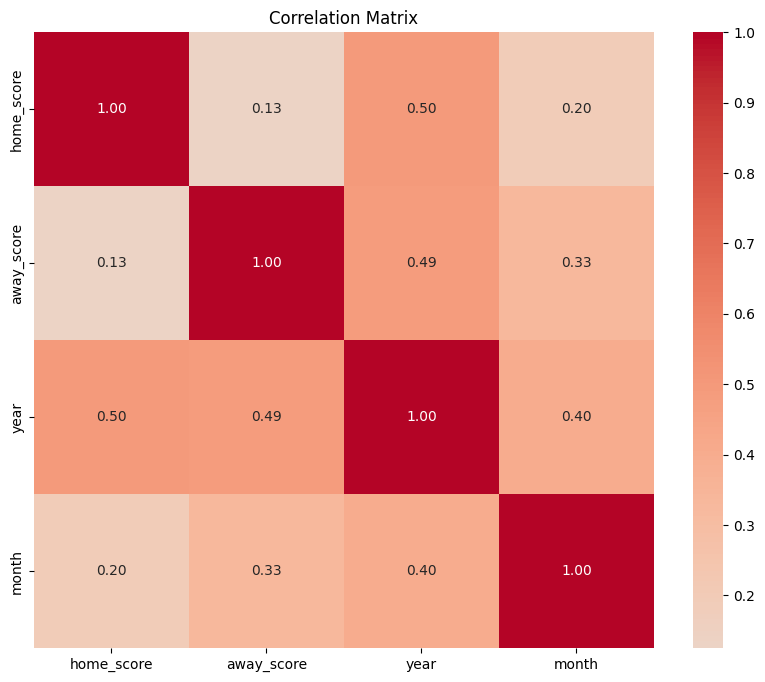

In [18]:
# This line creates the correlation matrix 
correlation_matrix = df[num_cols].corr()

# Plotting the heatmap correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# The Outliers and  Missing Values

In [19]:
# This function calculates the lower and upper thresholds for outliers using the interquartile range (IQR) method.
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)  # Calculate the 5th percentile
    quartile3 = dataframe[col_name].quantile(q3)  # Calculate the 95th percentile
    interquantile_range = quartile3 - quartile1  # Compute the IQR
    up_limit = quartile3 + 1.5 * interquantile_range  # Calculate the upper limit for outliers
    low_limit = quartile1 - 1.5 * interquantile_range  # Calculate the lower limit for outliers
    return low_limit, up_limit

# This function replaces outliers with the calculated upper and lower thresholds.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)  # Get outlier thresholds
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit  # Replace values below lower limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit  # Replace values above upper limit

# This function checks if there are outliers in a given column.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)  # Get outlier thresholds
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):  # Check for outliers
        return True
    else:
        return False

# For each numerical column, check for outliers and replace them if found.
for col in num_cols:
    print(col, check_outlier(df_wins, col))  # Print whether outliers are present
    if check_outlier(df_wins, col):  # If outliers exist, replace them with threshold values
        replace_with_thresholds(df_wins, col)

home_score False
away_score False
year False
month False


In [20]:
# This code drops the 'competition' and 'world_cup' columns from the dataframe.
df_wins = df_wins.drop(["competition", "world_cup"], axis=1)

In [21]:
# This line calls the 'grab_col_names' function to identify and separate different types of columns in the dataframe.
cat_cols, num_cols, cat_but_car = grab_col_names(df_wins)

Observations: 2662
Variables: 12
cat_cols: 6
num_cols: 4
cat_but_car: 2
num_but_cat: 0


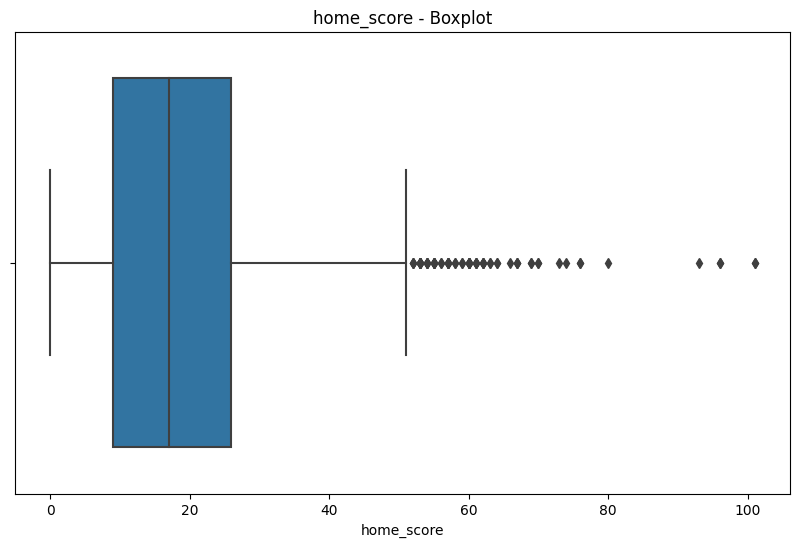

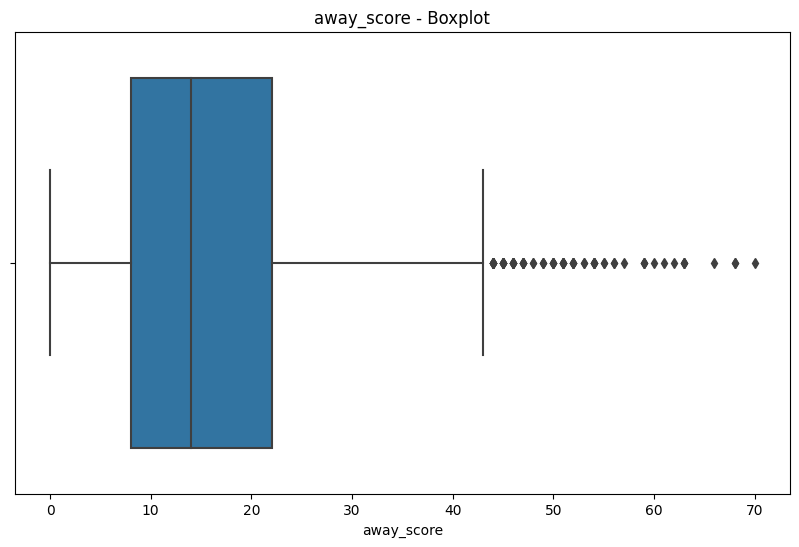

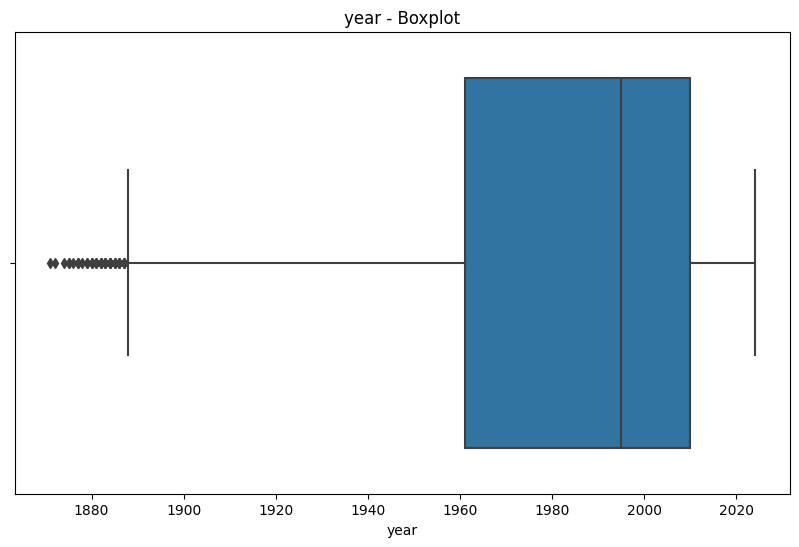

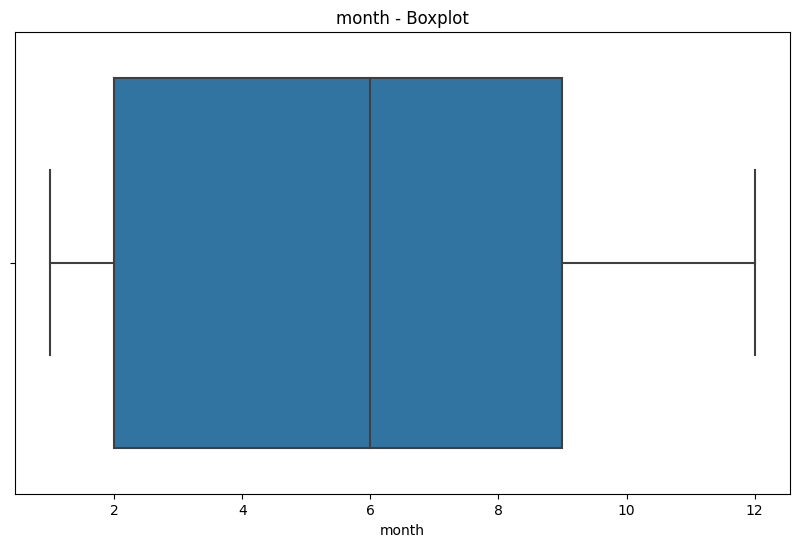

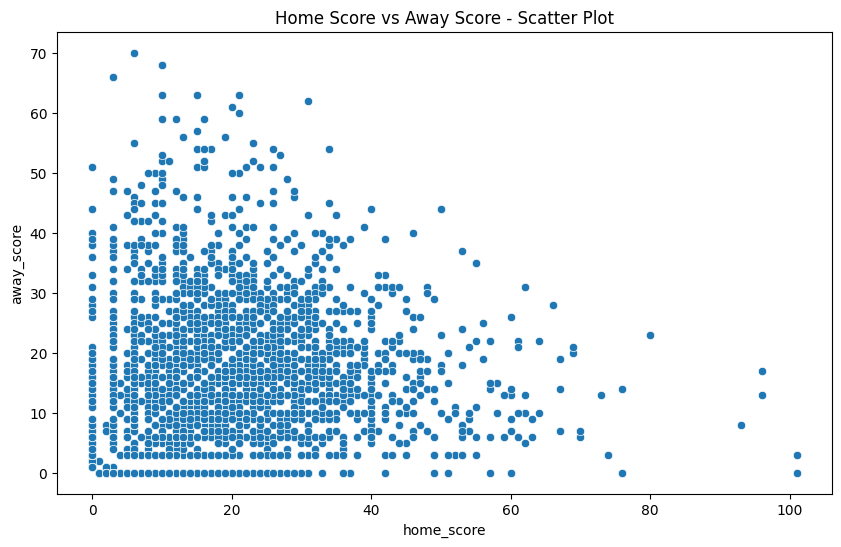

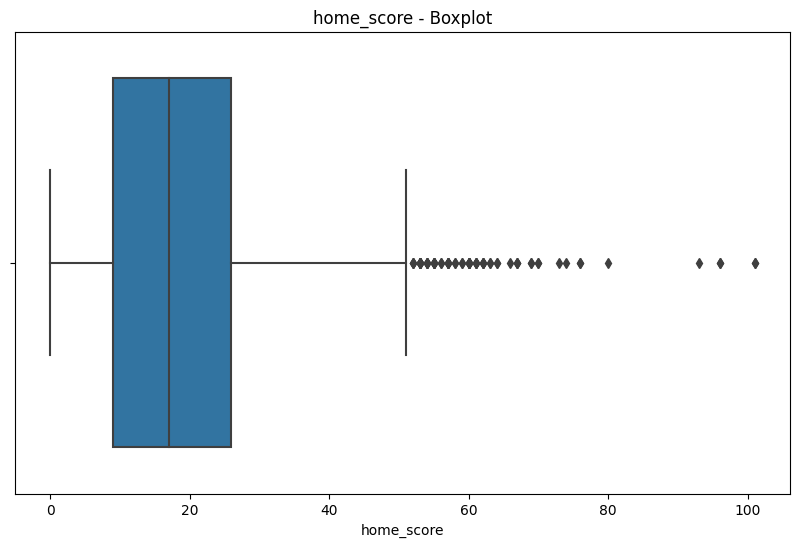

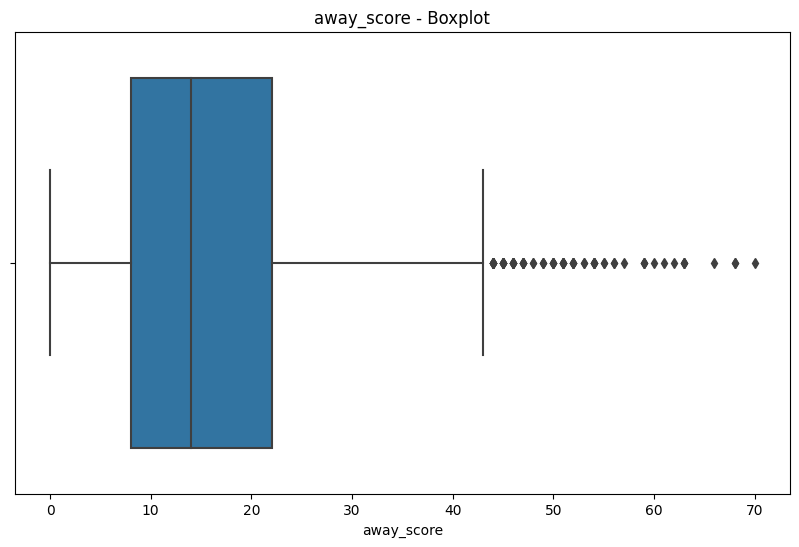

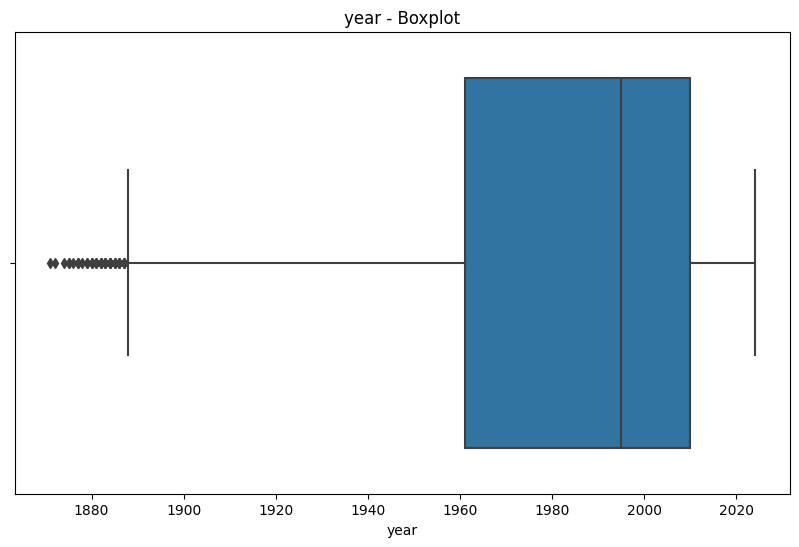

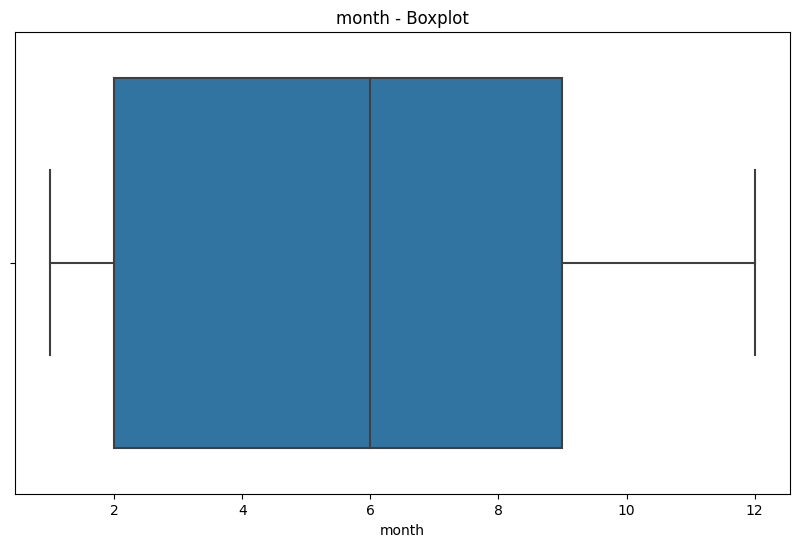

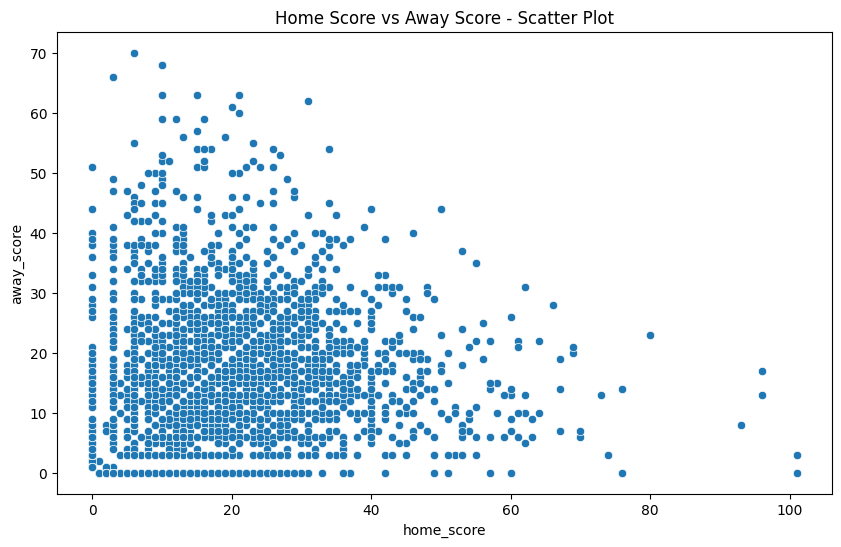

In [22]:
# This code creates boxplots for each numerical column in df_wins to visualize the distribution and detect outliers.
# It also creates a scatter plot to visualize the relationship between the home_score and away_score variables.
# The boxplots help to identify outliers in the individual numerical columns, and the scatter plot shows
# any patterns or correlations between home and away scores.
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_wins[col])
    plt.title(f"{col} - Boxplot")
    plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_wins['home_score'], y=df_wins['away_score'])
plt.title("Home Score vs Away Score - Scatter Plot")
plt.show()


for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_wins[col])
    plt.title(f"{col} - Boxplot")
    plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_wins['home_score'], y=df_wins['away_score'])
plt.title("Home Score vs Away Score - Scatter Plot")
plt.show()

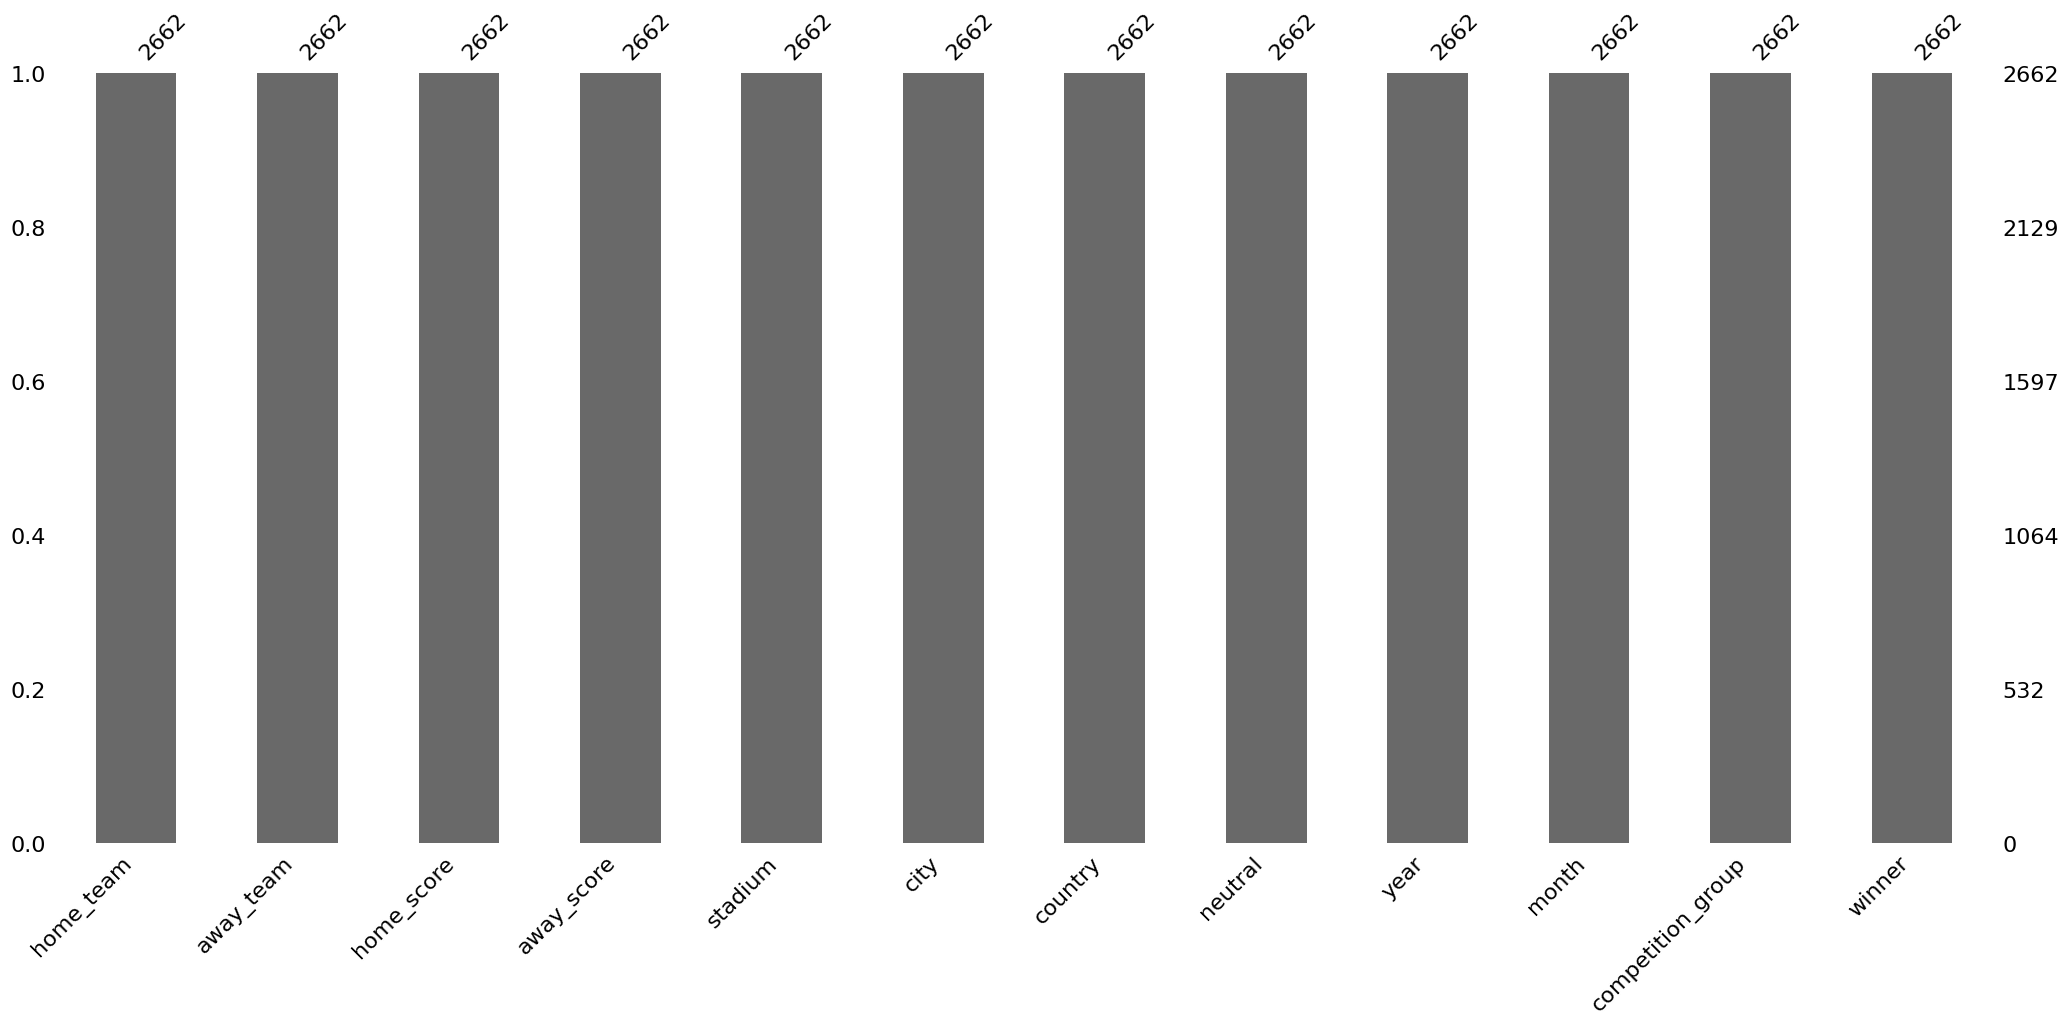

In [23]:
#displaying observations of all variables
msno.bar(df_wins)
plt.show()

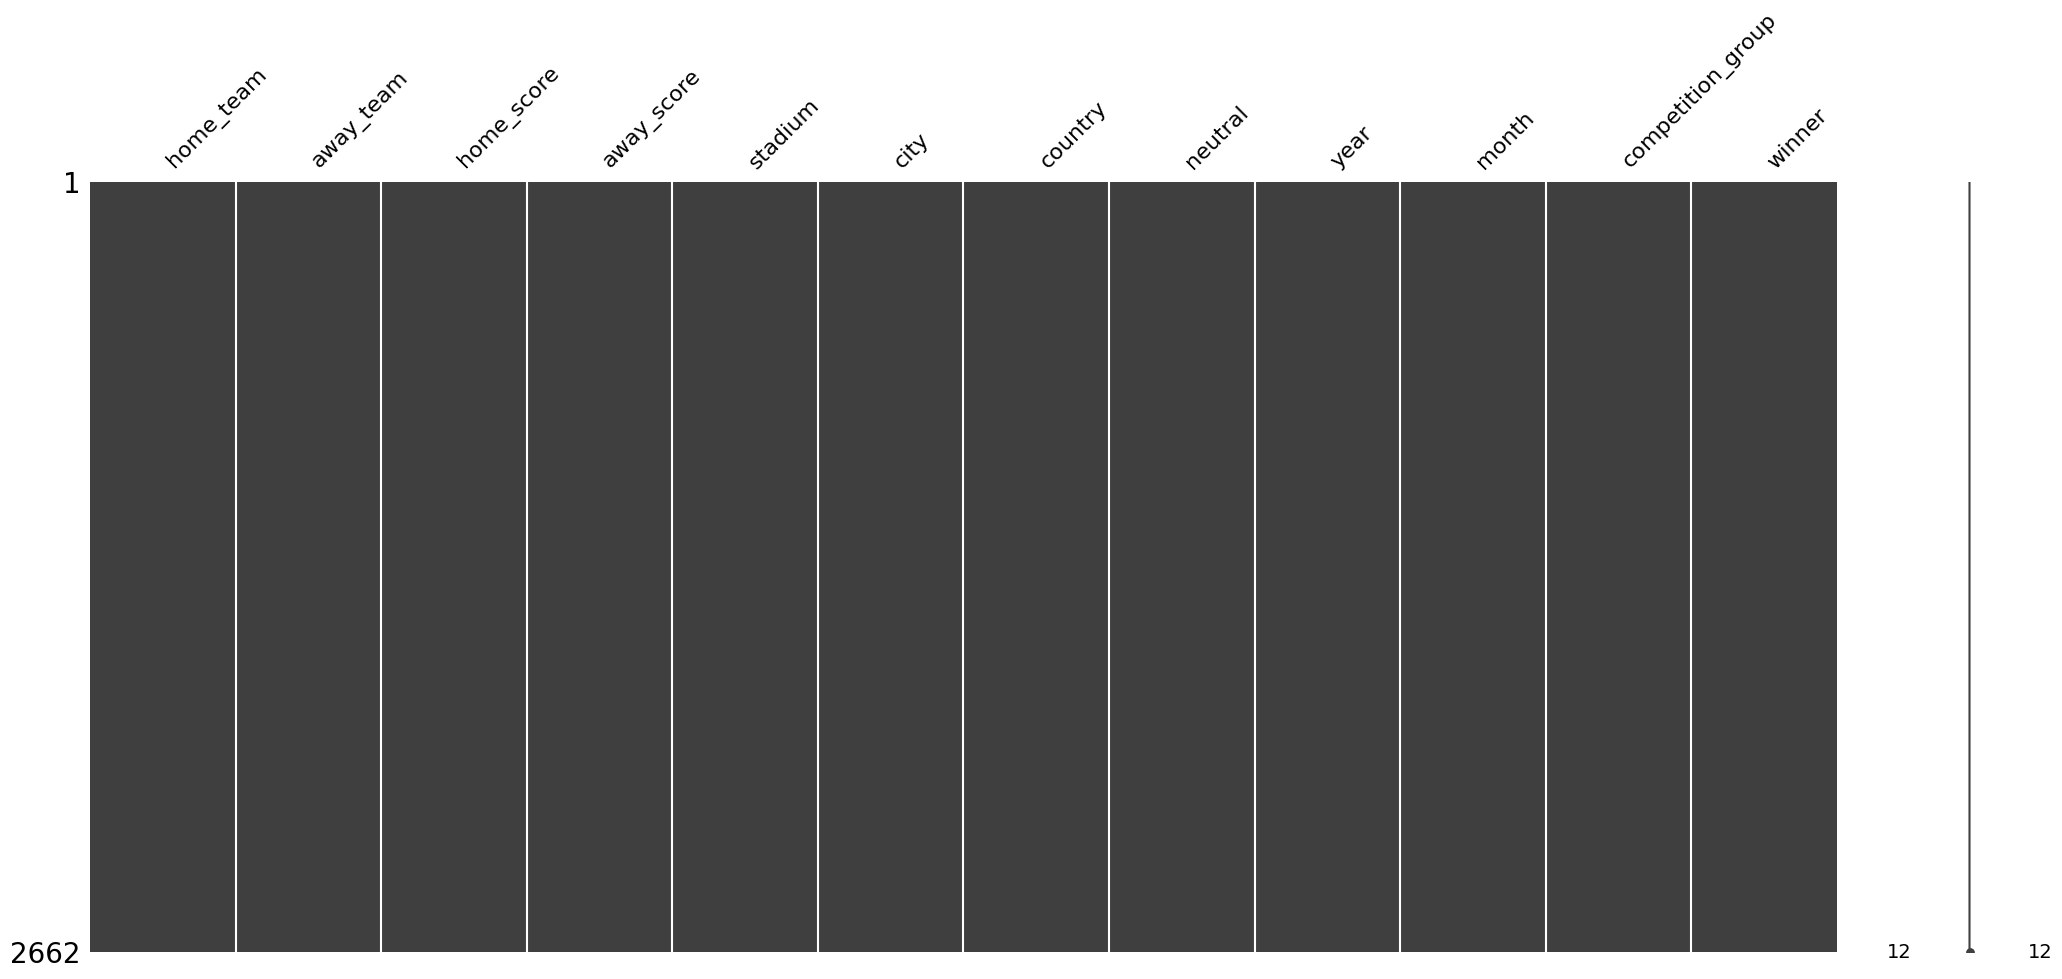

In [24]:
#displaying the missing values
msno.matrix(df_wins)
plt.show()

In [25]:
df_wins = df_wins[df_wins['winner'] != 'Draw']

# Base Model

In [26]:
############################################## BASE MODEL ##########################################
# This code builds a base model by preparing the data through one-hot encoding, scaling, 
# and transforming categorical variables. It defines various machine learning models (LR, KNN, CART, etc.),
# and evaluates them using cross-validation with custom scoring metrics (accuracy, AUC, precision, recall, and F1 score).
# The models' performance is then printed and visualized in bar charts.

# Copy the dataframe
dff = df_wins.copy()

# Grab categorical, numerical, and cardinal columns
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

# Exclude the 'winner' column from the categorical variables
cat_cols = [col for col in cat_cols if col not in ["winner"]]

# Show column information
dff.info()

# Function for one-hot encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

# Apply one-hot encoding to categorical columns
dff = one_hot_encoder(dff, cat_cols, drop_first=True)

# One-hot encode object and category columns, excluding 'winner'
ohe_cols = [col for col in dff.select_dtypes(include=['object', 'category']).columns if col != 'winner']
dff = one_hot_encoder(dff, ohe_cols)

# Update column lists
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

# Convert boolean columns to integers
bool_cols = dff.select_dtypes(include='bool').columns
dff[bool_cols] = dff[bool_cols].astype(int)

# Scale the numerical columns using RobustScaler
scaler = RobustScaler()
dff[num_cols] = scaler.fit_transform(dff[num_cols])

# Label encode the target column
dff.columns = dff.columns.str.replace(' ', '_')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dff['winner'])

# Drop the 'winner' column from the feature set
X = dff.drop("winner", axis=1)

# Define models to test
models = [('LR', LogisticRegression(random_state=24)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=24)),
          ('RF', RandomForestClassifier(random_state=24)),
          ('XGB', XGBClassifier(random_state=24)),
          ("LightGBM", LGBMClassifier(verbose=-1, random_state=24)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=24))]

# Define custom scoring metrics for multi-class AUC (using One-vs-Rest)
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1_macro',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
}

# Loop through models and evaluate them using cross-validation
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=scoring)

    # Print the results for each model
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"AUC: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")


Observations: 2662
Variables: 12
cat_cols: 6
num_cols: 4
cat_but_car: 2
num_but_cat: 0
<class 'pandas.core.frame.DataFrame'>
Index: 2662 entries, 0 to 2782
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   home_team          2662 non-null   object
 1   away_team          2662 non-null   object
 2   home_score         2662 non-null   int64 
 3   away_score         2662 non-null   int64 
 4   stadium            2662 non-null   object
 5   city               2662 non-null   object
 6   country            2662 non-null   object
 7   neutral            2662 non-null   bool  
 8   year               2662 non-null   int64 
 9   month              2662 non-null   int64 
 10  competition_group  2662 non-null   object
 11  winner             2662 non-null   object
dtypes: bool(1), int64(4), object(7)
memory usage: 252.2+ KB
Observations: 2662
Variables: 391
cat_cols: 387
num_cols: 4
cat_but_car: 0
num_but_cat: 0
##

# Feature Engineering

In [27]:
###### Feature Engineering ############
#Some new features have been commented later stage of the project to avoid data leakage 
# df_wins['new_score_difference'] = df_wins['home_score'] - df_wins['away_score']

# df_wins['new_total_score'] = df_wins['home_score'] + df_wins['away_score']

# df_wins['new_winning_margin'] = abs(df_wins['home_score'] - df_wins['away_score'])

#df['new_match_location'] = np.where(df['neutral'] == True, 'Neutral', 'Home')

# df_wins['new_match_outcome'] = np.where(df_wins['home_team_result'] == "Win", 'Home Win',
#                         np.where(df_wins['away_team_result'] == "Win", 'Away Win', 'Draw'))


# df_wins['new_home_team_winning_streak'] = df_wins.groupby('home_team')['home_team_result'].transform(lambda x: (x == "Win").cumsum())
# df_wins['new_away_team_winning_streak'] = df_wins.groupby('away_team')['away_team_result'].transform(lambda x: (x == "Win").cumsum())


df_wins['new_avg_home_score'] = df_wins.groupby('home_team')['home_score'].transform('mean')

df_wins['new_avg_away_score'] = df_wins.groupby('away_team')['away_score'].transform('mean')

#df['new_competition_importance'] = df['competition_group'].apply(lambda x: 'High' if 'world cup' in x.lower() or 'six nations' in x.lower() else 'Low')

# df_wins['new_home_team_strength'] = df_wins.groupby('home_team')['home_team_result'].transform(lambda x: (x == "Win").mean())
# df_wins['new_away_team_strength'] = df_wins.groupby('away_team')['away_team_result'].transform(lambda x: (x == "Win").mean())


df_wins['new_game_intensity'] = np.where(abs(df_wins['home_score'] - df_wins['away_score']) <= 5, 'High', 'Low')

# df_wins['new_home_win_loss_ratio'] = df_wins.groupby('home_team')['home_team_result'].transform(lambda x: (x == "Win").sum() / (x == "Loss").sum())
# df_wins['new_away_win_loss_ratio'] = df_wins.groupby('away_team')['away_team_result'].transform(lambda x: (x == "Win").sum() / (x == "Loss").sum())

# df_wins['new_home_competition_win_pct'] = df_wins.groupby(['home_team', 'competition_group'])['home_team_result'].transform(lambda x: (x == "Win").mean())
# df_wins['new_away_competition_win_pct'] = df_wins.groupby(['away_team', 'competition_group'])['away_team_result'].transform(lambda x: (x == "Win").mean())
# df_wins['new_home_avg_score_comp'] = df_wins.groupby(['home_team', 'competition_group'])['home_score'].transform('mean')
# df_wins['new_away_avg_score_comp'] = df_wins.groupby(['away_team', 'competition_group'])['away_score'].transform('mean')

In [28]:
# This line calls the 'grab_col_names' function to identify and separate different types of columns in the dataframe.
cat_cols, num_cols, cat_but_car = grab_col_names(df_wins)

Observations: 2662
Variables: 15
cat_cols: 7
num_cols: 6
cat_but_car: 2
num_but_cat: 0


# One Hot Encoding

In [29]:
# One Hot Encoder function
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [30]:
# Excluding the target variable 'winner' from One Hot encoded to be variables
ohe_cols = [col for col in df_wins.select_dtypes(include=['object', 'category']).columns if col != 'winner']

df_wins = one_hot_encoder(df_wins, ohe_cols)

In [31]:
# This code replaces whitespaces with underscores
df_wins.columns = df_wins.columns.str.replace(' ', '_')

In [32]:
df_wins.head()

,home_score,away_score,neutral,year,month,winner,new_avg_home_score,new_avg_away_score,home_team_Australia,home_team_England,home_team_France,home_team_Ireland,home_team_Italy,home_team_New_Zealand,home_team_Scotland,home_team_South_Africa,home_team_Wales,away_team_Australia,away_team_England,away_team_France,away_team_Ireland,away_team_Italy,away_team_New_Zealand,away_team_Scotland,away_team_South_Africa,away_team_Wales,stadium_AMI_Stadium,stadium_Adelaide_Oval,stadium_Allianz_Riviera,stadium_Arena_Civica,stadium_Ashton_Gate,stadium_Athletic_Ground,stadium_Athletic_Park,stadium_Aviva_Stadium,stadium_Ballymore,stadium_Ballymore_Stadium,stadium_Balmoral_Showgrounds,stadium_Bankwest_Stadium,stadium_Birkenhead_Park,stadium_Boet_Erasmus_Stadium,stadium_Brisbane_Cricket_Ground,stadium_Brisbane_Exhibition_Ground,stadium_Bruce_Stadium,stadium_Buffalo_City_Stadium,stadium_Canberra_Stadium,stadium_Cape_Town_Stadium,stadium_Cardiff_Arms_Park,stadium_Cardigan_Fields,stadium_Carisbrook,stadium_Cbus_Super_Stadium,stadium_Colombes,stadium_Colonial_Stadium,stadium_CommBank_Stadium,stadium_Concord_Oval,stadium_Croke_Park,stadium_Crown_Flatt,stadium_Crusaders_Ground,stadium_Crystal_Palace,stadium_Docklands_Stadium,stadium_EPRU_Stadium,stadium_Eden_Park,stadium_Ellis_Park,stadium_Ellis_Park_Stadium,stadium_Epsom_Showgrounds,stadium_Estadio_23_de_Agosto,stadium_Estadio_B.G_Estanislao_López,stadium_Estadio_Bicentenario,stadium_Estadio_Brigadier_General_Estanislao_López,stadium_Estadio_Centenario,stadium_Estadio_Estanislao_López,stadium_Estadio_Etcheverry,stadium_Estadio_Gigante_de_Arroyito,stadium_Estadio_Gimnasia_y_Esgrima_de_Buenos_Aires,stadium_Estadio_José_Amalfitani,stadium_Estadio_José_Fierro,stadium_Estadio_José_María_Minella,stadium_Estadio_Madre_de_Ciudades,stadium_Estadio_Malvinas_Argentinas,stadium_Estadio_Mario_Alberto_Kempes,stadium_Estadio_Monumental_José_Fierro,stadium_Estadio_Olímpico,stadium_Estadio_Padre_Ernesto_Martearena,stadium_Estadio_Raúl_Conti,stadium_Estadio_Ricardo_Etcheverry,stadium_Estadio_San_Juan_del_Bicentenario,stadium_Estadio_Único,stadium_Exhibition_Ground,stadium_FC_Oeste,stadium_FNB_Stadium,stadium_Fallowfield,stadium_Ferro_Carrill_Oeste,stadium_Ferrocaril_Oeste,stadium_Ferrocarril_Stadium,stadium_Forsyth_Barr_Stadium,stadium_Free_State_Stadium,stadium_Galpharm_Stadium,stadium_Gare_de_La_Croix_du_Prince,stadium_Gigante_de_Arroyito,stadium_Grand_Stade_Lille_Métropole,stadium_Hamilton_Crescent,stadium_Hampden_Park,stadium_Headingley,stadium_Hong_Kong_Stadium,stadium_International_Stadium_Yokohama,stadium_Inverleith,stadium_Jade_Stadium,stadium_Johann_van_Riebeeck_Stadium,stadium_José_Amalfitani,stadium_José_Amalfitani_Stadium,stadium_King's_Park,stadium_Kings_Park,stadium_Kings_Park_Stadium,stadium_Kingsholm,stadium_Kingsmead,stadium_Kingsmead_Cricket_Ground,stadium_Lancaster_Park,stadium_Lang_Park,stadium_Loftus_Versfeld,stadium_Loftus_Versfeld_Stadium,stadium_Malvinas_Argentinas,stadium_Mardyke,stadium_Mbombela_Stadium,stadium_McAlpine_Stadium,stadium_McDonald_Jones_Stadium,stadium_McDonald_Jones_stadium,stadium_McLean_Park,stadium_Meanwood_Road,stadium_Melbourne_Cricket_Ground,stadium_Melbourne_Rec._Stadium,stadium_Melbourne_Rectangular_Stadium,stadium_Millennium_Stadium,stadium_Monumental_José_Fierro,stadium_Mount_Smart_Stadium,stadium_Murrayfield,stadium_Murrayfield_Stadium,stadium_National_Stadium,stadium_Nelson_Mandela_Bay_Stadium,stadium_Newlands,stadium_Newlands_Stadium,stadium_Nissan_Stadium,stadium_North_Harbour_Stadium,stadium_North_Queensland_Stadium,stadium_Old_Trafford,stadium_Olympic_Park_Stadium,stadium_Olympic_Stadium,stadium_Optus_Stadium,stadium_Ormeau_Cricket_Ground,stadium_Otago_Stadium,stadium_Padre_Ernesto_Martearena,stadium_Pam_Brink_Stadium,stadium_Parc_Lescure,stadium_Parc_Olympique,stadium_Parc_des_Princes,stadium_Parc_y_Scarlets,stadium_Perth_Oval,stadium_Perth_Stadium,stadium_Powderhall_Stadium,stadium_RFK_Stadium,stadium_Raeburn_Place,stadium_Rathmines,stadium_Ravenhill,stadium_Rave

In [33]:
df_wins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2662 entries, 0 to 2782
Columns: 392 entries, home_score to new_game_intensity_Low
dtypes: bool(385), float64(2), int64(4), object(1)
memory usage: 1.1+ MB


In [34]:
# this code converts bool type variables to integer
bool_cols = df_wins.select_dtypes(include='bool').columns
df_wins[bool_cols] = df_wins[bool_cols].astype(int)

In [35]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_wins)

Observations: 2662
Variables: 392
cat_cols: 386
num_cols: 6
cat_but_car: 0
num_but_cat: 385


# Scaling The Data

In [36]:
# This code scales the munerical variables
scaler = RobustScaler()
df_wins[num_cols] =  scaler.fit_transform(df_wins[num_cols])
df_wins[num_cols].head()

,home_score,away_score,year,month,new_avg_home_score,new_avg_away_score
0,-0.941,-1.000,-2.531,-0.429,-0.633,0.000
1,-0.882,-0.929,-2.510,-0.571,0.000,-0.763
3,-0.941,-1.000,-2.469,-0.571,0.000,-0.763
4,-0.882,-1.000,-2.449,-0.571,0.000,-0.482
6,-1.000,-0.929,-2.449,0.857,-0.410,0.000


# Modelling

In [37]:
import pandas as pd
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# applying Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_wins['winner'])
X = df_wins.drop(["winner"], axis=1)

# defining the model objects 
models = [
    ('Logistic Regression', LogisticRegression(random_state=24)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=24)),
    ('Random Forest', RandomForestClassifier(random_state=24)),
    ('XGBoost', XGBClassifier(random_state=24)),
    ('LightGBM', LGBMClassifier(verbose=-1, random_state=24)),
    ('CatBoost', CatBoostClassifier(verbose=False, random_state=24))
]

# scorer for ROC AUC 
roc_auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)

# creating a dataframe to keep the results 
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'Recall', 'Precision', 'AUC'])

# creating a list to save the results in 
rows = []

# training the models with a loop and saving the results 
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring={
        "accuracy": "accuracy",
        "f1": "f1_weighted",
        "precision": "precision_weighted",
        "recall": "recall_weighted",
        "roc_auc": roc_auc_scorer})
    
    # saving the scores in the dict
    row = {
        'Model': name,
        'Accuracy': round(cv_results['test_accuracy'].mean(), 4),       
        'Precision': round(cv_results['test_precision'].mean(), 4),
        'Recall': round(cv_results['test_recall'].mean(), 4),
        'F1 Score': round(cv_results['test_f1'].mean(), 4),
        'AUC': round(cv_results['test_roc_auc'].mean(), 4)
    }
    rows.append(row)

# converting the list to a DataFrame
results_df = pd.DataFrame(rows)

# printing the results
results_df.sort_values(by="AUC", ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,AUC
4,XGBoost,0.917,0.922,0.917,0.916,0.997
6,CatBoost,0.885,0.891,0.885,0.882,0.992
5,LightGBM,0.899,0.911,0.899,0.896,0.991
3,Random Forest,0.759,0.773,0.759,0.752,0.963
0,Logistic Regression,0.668,0.678,0.668,0.655,0.957
1,KNN,0.724,0.740,0.724,0.720,0.928
2,Decision Tree,0.791,0.809,0.791,0.790,0.844


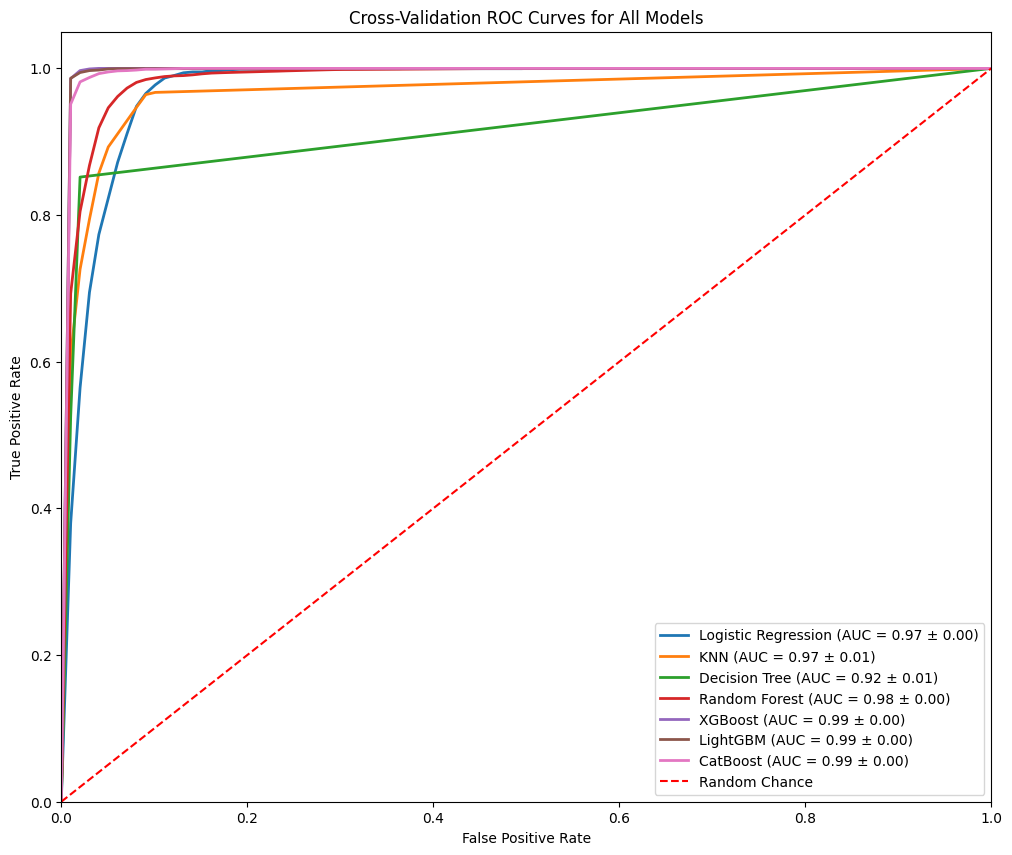

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_wins['winner'])
X = df_wins.drop(["winner"], axis=1)

# Binarize the target labels for multi-class ROC
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Define models
models = [
    ('Logistic Regression', LogisticRegression(random_state=24)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=24)),
    ('Random Forest', RandomForestClassifier(random_state=24)),
    ('XGBoost', XGBClassifier(random_state=24)),
    ('LightGBM', LGBMClassifier(verbose=-1, random_state=24)),
    ('CatBoost', CatBoostClassifier(verbose=False, random_state=24))
]

# Cross-Validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

# ROC Curve Plotting
plt.figure(figsize=(12, 10))
mean_fpr = np.linspace(0, 1, 100)

for name, model in models:
    tprs = []
    aucs = []
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_bin[train_index], y_bin[test_index]
        
        # Train the model
        model.fit(X_train, y[train_index])
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve and ROC AUC for each class and average
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    # Calculate the mean TPR and AUC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot ROC Curve
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

# Graph settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validation ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()

In [39]:
#Identifying the best model 
best_model_row = results_df.loc[results_df['F1 Score'].idxmax()]
best_model_name = best_model_row['Model']
print(f"The Best Model: {best_model_name}")

The Best Model: XGBoost


In [40]:
from sklearn.model_selection import GridSearchCV
import time

# Names of the best models
best_models = {
    'XGBoost': XGBClassifier(random_state=24),
    'LightGBM': LGBMClassifier(verbose=-1, force_col_wise=True, random_state=24),
    'CatBoost': CatBoostClassifier(verbose=False, random_state=24),
    'Random Forest': RandomForestClassifier(random_state=24)
}

# defining the hyperparameters' grid 
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50, 150],
    },
    'CatBoost': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 6]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 8, None],
        'min_samples_split': [2, 5, 8, 15, 20]
    }
}

# Run GridSearchCV for each model and find the best parameters
best_params = {}
training_times = {}
for name, model in best_models.items():
    print(f"Model: {name}")

    # Start value for time measurement 
    start_time = time.time()
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], 
                               cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
    grid_search.fit(X, y)

    # End the time measurement and calculate the duration
    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times[name] = elapsed_time
    
    best_params[name] = grid_search.best_params_
    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best F1 Score: {grid_search.best_score_:.4f}")
    print(f"Training time for {name}: {elapsed_time:.2f} seconds\n")

Model: XGBoost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
Best F1 Score: 0.9304
Training time for XGBoost: 568.74 seconds

Model: LightGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for LightGBM: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 150}
Best F1 Score: 0.9252
Training time for LightGBM: 112.70 seconds

Model: CatBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for CatBoost: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best F1 Score: 0.8632
Training time for CatBoost: 47.19 seconds

Model: Random Forest
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.7545
Training time for Random Forest: 250.91 seconds



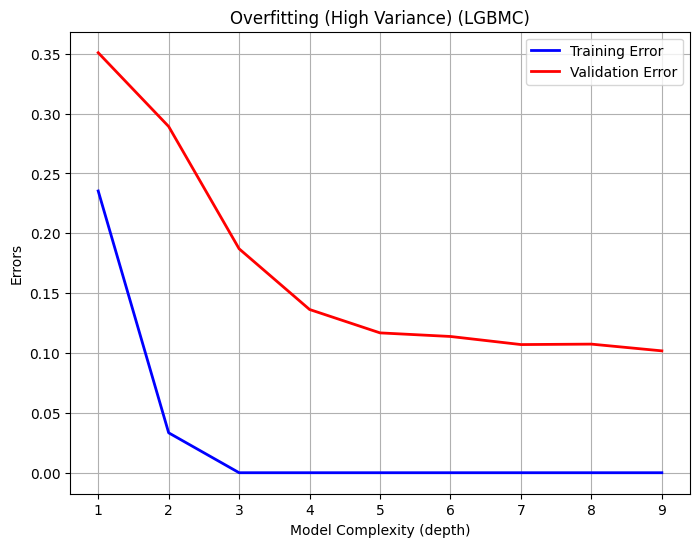

In [41]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier

# Define LightGBM model with the best hyperparameters
model = LGBMClassifier(verbose=-1, random_state=24)


# Defining the hyperparameter range 
param_range = range(1, 10)

# calculating the training and test scores for Validation curve 
train_scores, test_scores = validation_curve(
    model, X, y,
    param_name='max_depth', param_range=param_range,
    scoring="accuracy", cv=5, n_jobs=1)

# calculating the mean training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plotting the training and validation errors 
plt.figure(figsize=(8, 6))
plt.plot(param_range, 1 - train_scores_mean, label="Training Error", color='blue', lw=2)
plt.plot(param_range, 1 - test_scores_mean, label="Validation Error", color='red', lw=2)

# Graphic settings
plt.title('Overfitting (High Variance) (LGBMC)')
plt.xlabel('Model Complexity (depth)')
plt.ylabel('Errors')
plt.legend(loc="upper right")
plt.grid()

# Saving the Graph
plt.savefig("LGBMC_validation_curve.png")
plt.show()

# Final Model LightGBM

In [42]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score

# Define the feature set and the target variable
y = df_wins['winner']
X = df_wins.drop(["winner"], axis=1)

# Create the LightGBM model with the best parameters
final_lgbm = LGBMClassifier(
    learning_rate=0.01,
    n_estimators=200,
    num_leaves=150,
    max_depth=3,  
    class_weight='balanced',  
    verbose=-1
)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1_weighted',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
}

# Perform Stratified K-Fold Cross-Validation with multiple metrics
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)
cv_results = cross_validate(final_lgbm, X, y, cv=stratified_kfold, scoring=scoring)

# Print the mean of each score
print("Cross-validated Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-validated F1 Score:", cv_results['test_f1'].mean())
print("Cross-validated Precision:", cv_results['test_precision'].mean())
print("Cross-validated Recall:", cv_results['test_recall'].mean())
print("Cross-validated AUC:", cv_results['test_roc_auc'].mean())

# Fit the final model on the entire dataset
final_lgbm.fit(X, y)

Cross-validated Accuracy: 0.9214820759764579
Cross-validated F1 Score: 0.9215737592577454
Cross-validated Precision: 0.9262374594150831
Cross-validated Recall: 0.9214820759764579
Cross-validated AUC: 0.9971880875001284


LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=3,
               n_estimators=200, num_leaves=150, verbose=-1)

Classification Report:
               precision    recall  f1-score   support

   Argentina       0.86      0.93      0.90        74
   Australia       0.96      0.95      0.96       263
     England       0.97      0.96      0.97       391
      France       0.97      0.95      0.96       344
     Ireland       0.99      0.97      0.98       295
       Italy       0.73      1.00      0.84        27
 New Zealand       0.97      0.98      0.97       416
    Scotland       0.95      0.94      0.95       259
South Africa       0.95      0.98      0.96       271
       Wales       0.97      0.94      0.96       322

    accuracy                           0.96      2662
   macro avg       0.93      0.96      0.94      2662
weighted avg       0.96      0.96      0.96      2662



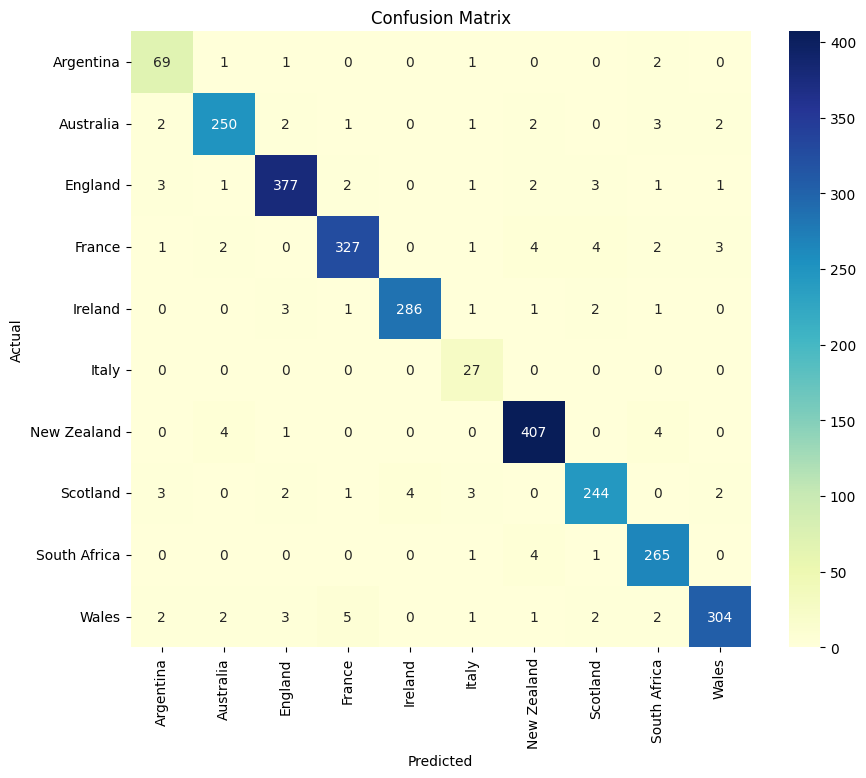

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the final model on the entire dataset (if not already fitted)
final_lgbm.fit(X, y)

# Generate predictions on the dataset
y_pred = final_lgbm.predict(X)

# Compute and display the classification report
report = classification_report(y, y_pred, target_names=final_lgbm.classes_)
print("Classification Report:\n", report)

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=final_lgbm.classes_, yticklabels=final_lgbm.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

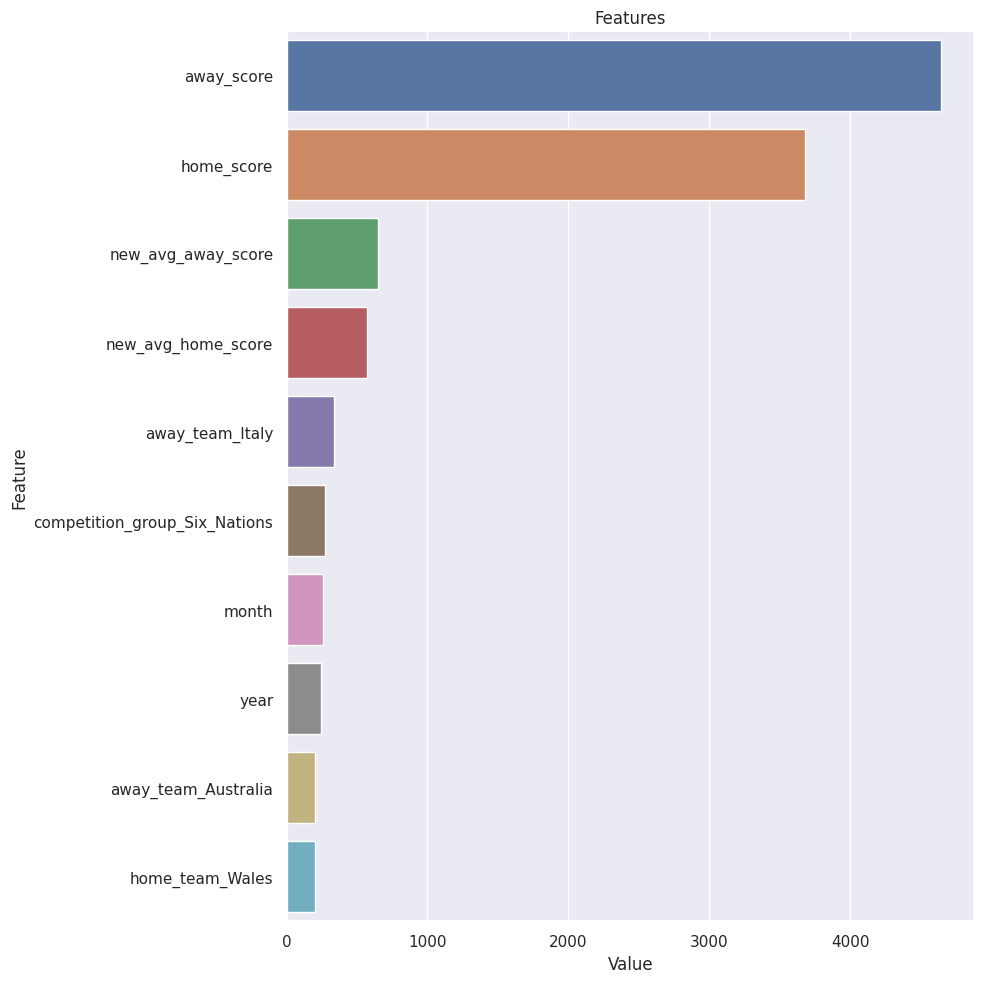

In [44]:
# plotting first 15 features of the feature importance 
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(final_lgbm, X, num=10)

**Conclusion**

Given the balance of performance and training time, LightGBM stands out as a robust choice for the final model. It provides near-top performance, high AUC, and more efficient training compared to XGBoost. However, LighGBM final model was established due to low training time.

Additionally, although label encoding was used here (despite classes being non-ordinal), it hasn’t drastically hurt model performance, especially for algorithms like LightGBM, CatBoost, and XGBoost, which handle categorical features well. However, it is still generally advisable to use models like CatBoost or LightGBM that can process categorical data natively without needing encoding.